In [1]:
%matplotlib inline

In [5]:
import hddm
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import scipy
import scipy.stats

## Outline of what I'd love to accomplish
* Excute Turner's Wald example here
* Write a PDA pseudo-likelihood function for 1D continuous data
* Try to run it on the HDDM example
* ???
* Profit?

### Turner's Wald example

In [67]:
theta = [2.2, 2, 0.1]
N = int(1e4)

mu = theta[0] / theta[1]
lambd = theta[0] ** 2

# inv_gaussian = scipy.stats.invgauss(mu * lambd, scale=lambd)

data = np.random.wald(mu, lambd, N)
# data = inv_gaussian.rvs(N) / lambd

def wald_pdf(x, mu, lambd):
    return (lambd / (2 * np.pi * (x ** 3))) ** 0.5 * np.exp(- lambd * (x - mu) ** 2 / (2 * (mu ** 2) * x))

data_range = max(data) - min(data)
plot_x = np.linspace(min(data) - data_range * 0.05, max(data) + data_range * 0.05, num=100)
plot_y = wald_pdf(plot_x, mu, lambd)

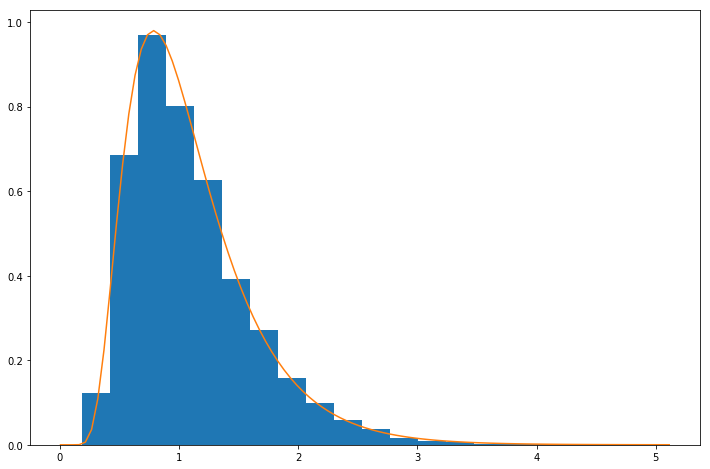

In [68]:
plt.figure(figsize=(12, 8))
plt.hist(data, bins=20, density=True)
plt.plot(plot_x, plot_y)

In [69]:
from sklearn.neighbors import KernelDensity

def silverman_bandwidth(x):
    sd = np.std(x)
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    return 0.9 * min(sd, iqr / 1.34) * len(x) ** (-1 / 5)

density = KernelDensity(bandwidth=silverman_bandwidth(data), kernel='epanechnikov')
density.fit(data.reshape((-1, 1)))
log_densities = density.score_samples(plot_x.reshape((-1, 1)))

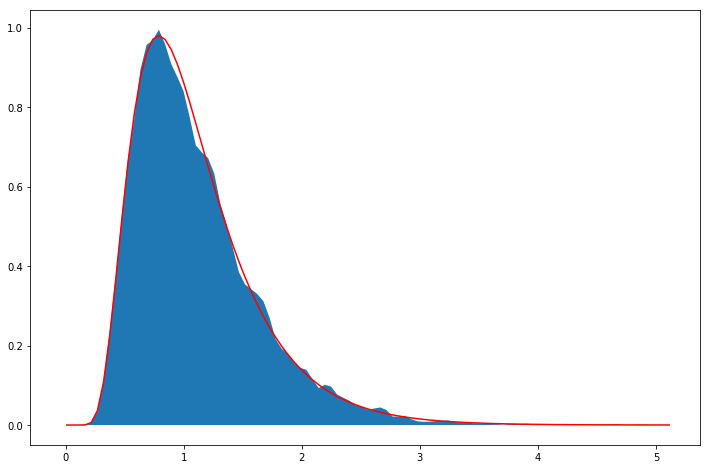

In [70]:
plt.figure(figsize=(12, 8))
plt.fill(plot_x, np.exp(log_densities))
plt.plot(plot_x, plot_y, color='red')

### 1-D continuous PDA psuedo-likelihood
_TODO:_
* Let's start with just capturing response times, without distringuishing positive and negtive
    * But isn't the drift rate for them different? Apparently not, according to the model
        * But if there's only one drift rate, how do failures happen? Is my model just off?
    * How do I convert from 'timeless' steps in the simulation to the RTs in seconds?
    * Keep track of success / failure - not too hard, I guess, just check if passed the top barrier or bottom?
    * Am I using the correct distributions?
    * Can I vectorize this more? Probably
* To do the above, we'd need to build a 2d kernel, with the choice being binary (discrete)
* Remove trajectories, currently using them only to debug

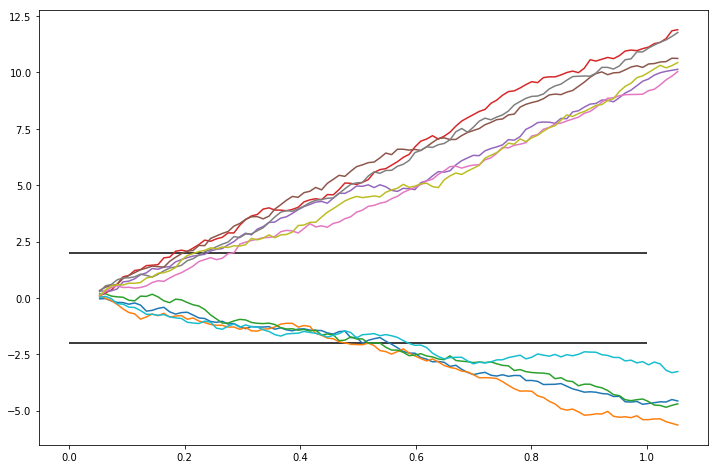

In [85]:
z = np.random.normal(0, 0.1)
t = np.abs(np.random.normal(0, 0.1))
n_steps = 100

plt.figure(figsize=(12, 8))
plt.hlines([-2, 2], 0, 1)

for _ in range(10):
    x_values = np.linspace(0, 1, n_steps) + t
    v_values = np.random.normal(np.random.choice([0.1, -0.05]), 0.1, n_steps)
    y_values = np.cumsum(v_values) + z
    
    plt.plot(x_values, y_values)


In [90]:
def silverman_bandwidth(x):
    sd = np.std(x)
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    return 0.9 * min(sd, iqr / 1.34) * len(x) ** (-1 / 5)

def PDA_pseudo_likelihood_generator(sampler, n_samples):
    def logp_(observed_data):
        samples = sampler(n_samples)
        bandwidth = silverman_bandwidth(samples)
        
        density = KernelDensity(bandwidth=silverman_bandwidth(samples), kernel='epanechnikov')
        density.fit(samples.reshape((-1, 1)))
        return density.score_samples(observed_data.reshape((-1, 1)))
    
    return logp_

def build_drift_diffusion_sampler(v, sv, a, z, sz, t, st):
    def sampler(n_samples):
        samples = []
        trajectories = []
        for _ in range(n_samples):
            z_i = np.random.normal(z, sz)
            t_i = abs(np.random.normal(t, st)) 
            
            v_values = np.random.normal(v, sv, 100)
            values = np.cumsum(v_values) + z_i
            upper_passage = np.argmax(values > a / 2)
            lower_passage = np.argmax(values < -a / 2)
            
            if upper_passage == 0:
                samples.append(lower_passage + t_i) # convert lower_passage to t!
                trajectories.append(values[:lower_passage])
            elif lower_passage == 0: 
                samples.append(upper_passage + t_i) # same note as above
                trajectories.append(values[:upper_passage])
            else:
                samples.append(min(lower_passage, upper_passage) + t_i) # same note as above
                trajectories.append(values[min(lower_passage, upper_passage)])
                
        return samples, trajectories
                
    return sampler
            

    

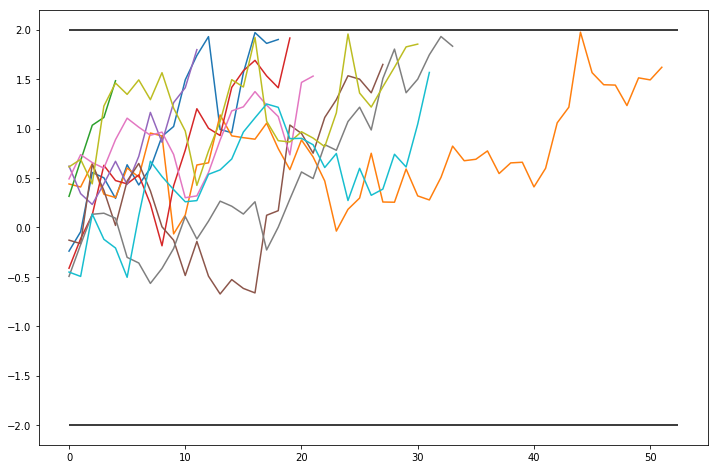

In [96]:
sampler = build_drift_diffusion_sampler(0.1, 0.3, 4, 0, 0.2, 0, 4)

samples, trajectories = sampler(10)

plt.figure(figsize=(12, 8))
plt.hlines([-2, 2], 0, max(samples))

for traj in trajectories:
    x_values = range(len(traj))
    plt.plot(x_values, traj)

In [ ]:
data = hddm.load_csv('./data/cavanagh_theta_nn.csv')
data.head(10)

hddm_model = pm.Model()
num_subjects = len(set(data.subj_idx))
subject_idx = data.subj_idx.values
rts = data['rt'].values


with hddm_model:
    # Let's specify some priors
    mu_a = pm.Gamma('mu_a', mu=1.5, sd=0.75)
    sigma_a = pm.HalfNormal('sigma_a', sd=0.1)
    
    mu_v = pm.Normal('mu_v', mu=2, sd=3)
    sigma_v = pm.HalfNormal('sigma_v', sd=2)
    
    mu_z = pm.Normal('mu_z', mu=0.5, sd=0.5)
    sigma_z = pm.HalfNormal('sigma_z', sd=0.05)
    
    mu_t = pm.Gamma('mu_t', mu=0.4, sd=0.2)
    sigma_t = pm.HalfNormal('sigma_t', sd=1)
    
    sv = pm.HalfNormal('sv', sd=2)
    st = pm.HalfNormal('st', sd=0.3)
    sz = pm.Beta('sz', alpha=1, beta=3)
    
    a = pm.Gamma('a', mu=mu_a, sd=sigma_a, shape=num_subjects)
    v = pm.Normal('v', mu=mu_v, sd=sigma_v, shape=num_subjects)
    z_raw = pm.Normal('z_raw', mu=mu_z, sd=sigma_z, shape=num_subjects)
    z = pm.Deterministic('z', pm.invlogit(z_raw))
    t = pm.Normal('t', mu=mu_t, sd=sigma_t, shape=num_subjects)

    
    
